# Previsão de aluguel utilizando Regressão Linear
 Neste projeto, vamos utilizar os algorítimos **Random Forest** e **XgBoost** para realizar a predição de aluguéis para uma imobiliária utilizando seu banco de dados como referência.

<img src="https://img.shields.io/badge/Python-3.10.0%2B-orange" alt="drawing" width="80"/>

[![](https://img.shields.io/badge/Apache-License-green)](https://github.com/rgizsilva/Analise-de-dados-acidentes-rodoviarios/blob/main/LICENSE)

[![](https://img.shields.io/badge/Linkedin-Reginaldo-blue )](https://www.linkedin.com/in/rgiz/)

<img src="https://painel.wmb.com.br/cdn/bco_img/19376/outros/PIarwniladsauq.jpg" alt="drawing" width="850"/>


-----

Vamos começar importando todas as bibliotecas necessárias para o projeto

In [462]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from category_encoders.one_hot import OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBRFRegressor
from skopt import gp_minimize
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

Nosso banco de dados pode ser encontrado em 
https://www.kaggle.com/datasets/rubenssjr/brasilian-houses-to-rent?select=houses_to_rent_v2.csv

In [419]:
#Carregando o banco de dados 
df = pd.read_csv("https://raw.githubusercontent.com/rgizsilva/Regressao_alugueis/main/houses_to_rent_v2.csv",sep=',')

In [420]:
#Verificando número de linhas e colunas
df.shape

(10692, 13)

In [421]:
#conferindo os últimos 5 registros
df.tail(5)

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,402,1478,24,22,1926
10688,São Paulo,285,4,4,4,17,acept,not furnished,3100,15000,973,191,19260
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,980,6000,332,78,7390
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,1585,12000,279,155,14020
10691,São Paulo,80,2,1,0,-,acept,not furnished,0,1400,165,22,1587


## Dicionário de dados

**city** - Cidade onde o imóvel está localizada\
**area** - Area do imovel\
**rooms** - Número de quartos\
**bathroom** - Número de banheiros\
**parking spaces** - Número de vagas \
**floor** - Número do andar\
**animal** - Se o imóvel aceita animais\
**furniture** - Se o imóvel está mobilhado\
**hoa(RS)** - Valor do condomínio\
**rent amount (RS)** - Valor do Aluguel\
**property tax (RS)** - Valor do IPTU\
**fire insurance (RS)** - Valor do seguro incêndio\
**total (RS)** - Total da soma dos valores\










## Limpeza dos dados

Vamos modificar o nome das colunas para melhor compreensão.Vamos excluir a coluna **Total(R$)**, pois não será usada em nossa predição.

In [422]:
#vamos traduzir o nome dos campos de inglês para português
df.rename({'city': 'cidade','area':'area_imovel_metros','rooms':'quartos','bathroom':'banheiro',
          'parking spaces':'n_vagas','floor':'n_andar','animal':'aceita_animal',
          'furniture':'mobilhada','hoa (R$)':'valor_condominio','property tax (R$)':'valor_iptu',
           'fire insurance (R$)':'seguro_incendio','rent amount (R$)':'valor_aluguel'}, axis = 1,inplace=True)

df.loc[df['aceita_animal'] == 'acept', 'aceita_animal'] = 'aceita'
df.loc[df['aceita_animal'] == 'not acept', 'aceita_animal'] = 'não aceita'
df.loc[df['mobilhada'] == 'not furnished', 'mobilhada'] = 'não mobilhada'
df.loc[df['mobilhada'] == 'furnished', 'mobilhada'] = 'mobilhada'

#ordenando as colunas
df = df[['cidade','area_imovel_metros', 'quartos','banheiro','n_vagas','n_andar','aceita_animal','mobilhada',
         'valor_condominio','valor_iptu','seguro_incendio','valor_aluguel']]

In [423]:
#conferir os tipos das variáveis
df.dtypes

cidade                object
area_imovel_metros     int64
quartos                int64
banheiro               int64
n_vagas                int64
n_andar               object
aceita_animal         object
mobilhada             object
valor_condominio       int64
valor_iptu             int64
seguro_incendio        int64
valor_aluguel          int64
dtype: object

In [424]:
#Substituindo o campo '-' por '0'
df.loc[df['n_andar'] == '-', 'n_andar'] = 0

#alterando tipo das variáveis
df['n_andar'] = df['n_andar'].astype(int)
df['valor_condominio'] = df['valor_condominio'].astype(float)
df['valor_aluguel'] = df['valor_aluguel'].astype(float)
df['valor_iptu'] = df['valor_iptu'].astype(float)
df['seguro_incendio'] = df['seguro_incendio'].astype(float)

Vamos conferir valores ausentes/nulos

In [425]:
df.isnull().sum().sort_values(ascending= False)

cidade                0
area_imovel_metros    0
quartos               0
banheiro              0
n_vagas               0
n_andar               0
aceita_animal         0
mobilhada             0
valor_condominio      0
valor_iptu            0
seguro_incendio       0
valor_aluguel         0
dtype: int64

## Descrição estatística e correção de *outliers*

In [426]:
#descrição estatística
df.describe()

,area_imovel_metros,quartos,banheiro,n_vagas,n_andar,valor_condominio,valor_iptu,seguro_incendio,valor_aluguel
count,10692.000000,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000
mean,149.217920,2.506079,2.236813,1.609147,5.067995,1.174022e+03,366.704358,53.300879,3896.247194
std,537.016942,1.171266,1.407198,1.589521,6.069050,1.559231e+04,3107.832321,47.768031,3408.545518
min,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,3.000000,450.000000
25%,56.000000,2.000000,1.000000,0.000000,1.000000,1.700000e+02,38.000000,21.000000,1530.000000
50%,90.000000,2.000000,2.000000,1.000000,3.000000,5.600000e+02,125.000000,36.000000,2661.000000
75%,182.000000,3.000000,3.000000,2.000000,8.000000,1.237500e+03,375.000000,68.000000,5000.000000
max,46335.000000,13.000000,10.000000,12.000000,301.000000,1.117000e+06,313700.000000,677.000000,45000.000000


In [427]:
#descrição estatística variáveis não númericas
df.describe(include = ['object'])

,cidade,aceita_animal,mobilhada
count,10692,10692,10692
unique,5,2,2
top,São Paulo,aceita,não mobilhada
freq,5887,8316,8086


Existem alguns valores fora do padrão, por isso vamos verificar e corrigir valores outlier's


<AxesSubplot:>

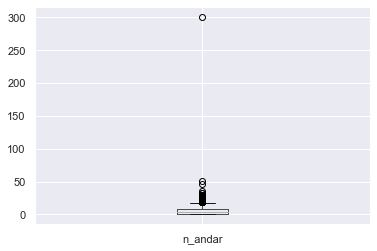

In [428]:
#gerando gráfico de Boxplot para conferir outliers
df.boxplot('n_andar')

In [429]:
#Removendo valores outliers
remove= df.loc[(df['n_andar'] > 70)]
df = df.drop(remove.index)

<AxesSubplot:>

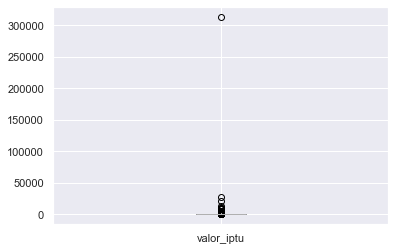

In [430]:
#gerando gráfico de Boxplot para conferir outliers
df.boxplot('valor_iptu')

In [431]:
#Removendo valores outliers
remove= df.loc[(df['valor_iptu'] > 15000)]
df = df.drop(remove.index)

<AxesSubplot:>

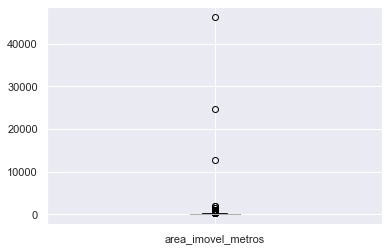

In [432]:
#gerando gráfico de Boxplot para conferir outliers
df.boxplot('area_imovel_metros')

In [433]:
#Removendo valores outliers
remove= df.loc[(df['area_imovel_metros'] > 2000)]
df = df.drop(remove.index)

<AxesSubplot:>

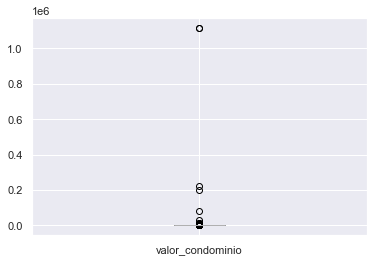

In [434]:
#gerando gráfico de Boxplot para conferir outliers
df.boxplot('valor_condominio')

In [435]:
#Removendo valores outliers
remove= df.loc[(df['valor_condominio'] > 8000)]
df = df.drop(remove.index)

In [436]:
#conferindo total de linha e colunas
df.shape

(10664, 12)

In [437]:
#descrição estatística
df.describe()

,area_imovel_metros,quartos,banheiro,n_vagas,n_andar,valor_condominio,valor_iptu,seguro_incendio,valor_aluguel
count,10664.000000,10664.000000,10664.000000,10664.000000,10664.000000,10664.000000,10664.000000,10664.000000,10664.000000
mean,140.715023,2.503095,2.231058,1.604182,5.040885,902.957989,327.533758,53.124437,3882.552982
std,132.940353,1.168850,1.401044,1.584006,5.355068,1072.455726,576.124145,47.563802,3390.934306
min,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,450.000000
25%,56.000000,2.000000,1.000000,0.000000,1.000000,170.000000,38.000000,21.000000,1524.500000
50%,90.000000,2.000000,2.000000,1.000000,3.000000,555.000000,125.000000,36.000000,2650.000000
75%,180.000000,3.000000,3.000000,2.000000,8.000000,1224.250000,375.000000,68.000000,5000.000000
max,2000.000000,13.000000,10.000000,12.000000,51.000000,8000.000000,12500.000000,677.000000,45000.000000


Vamos conferir quais são as cidades presentes em nossos dados

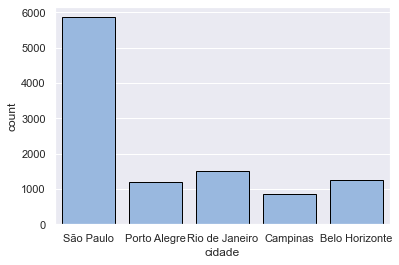

In [513]:
sns.set()
plot = sns.countplot(x = df['cidade'],color='#8db7eb',edgecolor='black')


## Transformando as variáveis categóricas utilizando One Hot Encoder e Label Encoder
**One Hot Encoder** irá criar colunas para cada cidade existente na nossa variável **cidade**, são as chamadas variáveis **dummies**\
**Label Encoder** irá alterar o valor das nossas variáveis **aceita_animal** e **mobilhada** para **1** se positivo, e **0** se negativo

In [439]:
#Utilizando codificação One Hot Encoder
ohe = OneHotEncoder(cols=['cidade'],use_cat_names=True)
df_ohe = ohe.fit_transform(df)

In [440]:
#Utilizando codificação Label Encoder
oe = preprocessing.LabelEncoder()
df_ohe['aceita_animal'] = oe.fit_transform(df['aceita_animal'])
df_ohe['mobilhada'] = oe.fit_transform(df['mobilhada'])

In [441]:
#Verificando novos dados
df_ohe

,cidade_São Paulo,cidade_Porto Alegre,cidade_Rio de Janeiro,cidade_Campinas,cidade_Belo Horizonte,area_imovel_metros,quartos,banheiro,n_vagas,n_andar,aceita_animal,mobilhada,valor_condominio,valor_iptu,seguro_incendio,valor_aluguel
0,1,0,0,0,0,70,2,1,1,7,0,0,2065.0,211.0,42.0,3300.0
1,1,0,0,0,0,320,4,4,0,20,0,1,1200.0,1750.0,63.0,4960.0
2,0,1,0,0,0,80,1,1,1,6,0,1,1000.0,0.0,41.0,2800.0
3,0,1,0,0,0,51,2,1,0,2,0,1,270.0,22.0,17.0,1112.0
4,1,0,0,0,0,25,1,1,0,1,1,1,0.0,25.0,11.0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,0,1,0,0,0,63,2,1,1,5,1,0,402.0,24.0,22.0,1478.0
10688,1,0,0,0,0,285,4,4,4,17,0,1,3100.0,973.0,191.0,15000.0
10689,0,0,1,0,0,70,3,3,0,8,1,0,980.0,332.0,78.0,6000.0
10690,0,0,1,0,0,120,2,2,2,8,0,0,1585.0,279.0,155.0,12000.0


## Verificando correlação das variáveis 
Vamos verificar a correlação das nossas variáveis, a correlação forte é de **-1**, e **1**.\
Uma correlação forte das nossas variáveis pode atrapalhar nosso algorítimo de predição, pois o valor de uma variável pode estar ligado a diretamente ao valor de outra, fazendo nosso algorítimo viciar, e ficar com *overfitting*

In [442]:
#Instanciando a correlção das nossas variáveis
correlacao = df_ohe.corr()
correlacao

,cidade_São Paulo,cidade_Porto Alegre,cidade_Rio de Janeiro,cidade_Campinas,cidade_Belo Horizonte,area_imovel_metros,quartos,banheiro,n_vagas,n_andar,aceita_animal,mobilhada,valor_condominio,valor_iptu,seguro_incendio,valor_aluguel
cidade_São Paulo,1.000000,-0.392320,-0.447258,-0.325885,-0.403717,0.105841,0.047148,0.179942,0.184610,0.121872,0.043827,-0.069608,0.178414,0.198828,0.209330,0.243680
cidade_Porto Alegre,-0.392320,1.000000,-0.143467,-0.104534,-0.129500,-0.098882,-0.109665,-0.127758,-0.125170,-0.074681,-0.054985,-0.019668,-0.144813,-0.125274,-0.124390,-0.161480
cidade_Rio de Janeiro,-0.447258,-0.143467,1.000000,-0.119172,-0.147635,-0.107433,-0.089364,-0.136990,-0.219502,0.015756,-0.024015,-0.024836,0.046421,-0.067183,-0.090554,-0.077567
cidade_Campinas,-0.325885,-0.104534,-0.119172,1.000000,-0.107571,-0.039758,-0.037473,-0.056993,-0.008246,-0.041778,-0.024354,0.077912,-0.075322,-0.091976,-0.128392,-0.131866
cidade_Belo Horizonte,-0.403717,-0.129500,-0.147635,-0.107571,1.000000,0.082651,0.162422,0.042857,0.081116,-0.097000,0.032511,0.087960,-0.120575,-0.034617,0.004168,-0.023689
area_imovel_metros,0.105841,-0.098882,-0.107433,-0.039758,0.082651,1.000000,0.694060,0.754440,0.688340,-0.108727,-0.130055,0.008247,0.295387,0.620873,0.699488,0.663639
quartos,0.047148,-0.109665,-0.089364,-0.037473,0.162422,0.694060,1.000000,0.733106,0.616070,-0.091236,-0.172515,0.081290,0.284044,0.460033,0.563111,0.539597
banheiro,0.179942,-0.127758,-0.136990,-0.056993,0.042857,0.754440,0.733106,1.000000,0.695964,0.007116,-0.120020,-0.017654,0.412816,0.584524,0.675068,0.667171
n_vagas,0.184610,-0.125170,-0.219502,-0.008246,0.081116,0.688340,0.616070,0.695964,1.000000,-0.024306,-0.128650,0.004671,0.287919,0.536056,0.596244,0.577041
n_andar,0.121872,-0.074681,0.015756,-0.041778,-0.097000,-0.108727,-0.091236,0.007116,-0.024306,1.000000,0.028063,-0.123401,0.364695,0.068345,0.018357,0.086707


<AxesSubplot:>

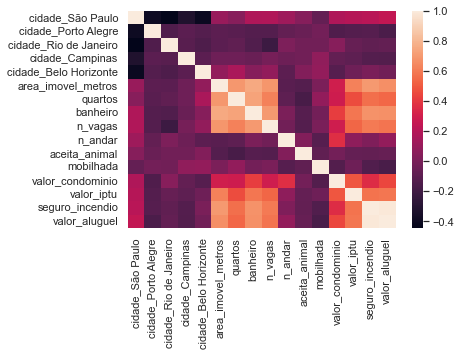

In [443]:
#Mapa de correlação entre as variáveis
sns.heatmap(correlacao)

<AxesSubplot:xlabel='valor_aluguel', ylabel='seguro_incendio'>

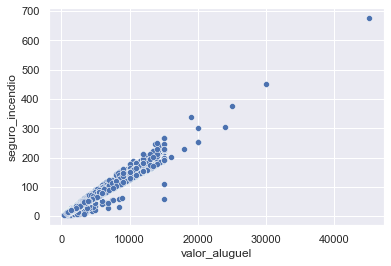

In [444]:
#Grágico de ScatterPlot mostra a colinearidade das nossas variáveis
sns.scatterplot(data=df_ohe, x="valor_aluguel", y="seguro_incendio")

Podemos perceber que a nossa variável **seguro_incendio** é colinear, pois possuí uma correlação positiva quase perfeita com a nossa variável alvo **valor_aluguel**.\
Para evitar *overfitting* do nosso modelo de predição, vamos excluir ela de nossas **features**

In [445]:
#Eliminar a variavel seguro_incendio
df_ohe = df_ohe.drop(['seguro_incendio'],axis=1)


## Separar dados de teste e validação para nosso algorítimo
Vamos separar nossas features da variável alvo **valor_aluguel**

In [446]:
# fazer separação do dataset em treino e teste
X = df_ohe.drop('valor_aluguel',axis=1)
y = df_ohe['valor_aluguel']

Xtr,Xval,ytr,yval = train_test_split(X,y,test_size= 0.3,random_state=0)

## Criando Base Line com Random Forest
Vamos criar um esboço como uma base para ser batida. Vamos utilizar o algorítimo **Random Forest** como **Regressão** para nossa base, e o **erro quadrático médio** como métrica para validar nosso modelo.\
A ideia é usar essa base de erro para criarmos um modelo de **XGBoost** de regressão para superar nossa base.

In [447]:
#instanciando o modelo com Random Forest
arvores = RandomForestRegressor(n_estimators=1000,min_samples_leaf=1,random_state=0)
#Treinando o modelo
arvores.fit(Xtr,ytr)

p = arvores.predict(Xval)

#Utilizando o erro quadrático como métrica
np.sqrt(mean_squared_error(yval,p))



2093.693972189584

nosso erro quadrático médio da baseline com random forest é de aprox. 2093

## Otimização Bayesiana
Vamos utilizar a **otimização Bayesiana** para tunar os hiperparâmetros do nosso modelo de **XGBoost**\
Ela vai percorrer os parâmetros até encontrar a melhor combinação para nosso modelo.\
Como espaços para encontrar nossa melhor otimização, vamos utilizar os **processos gaussianos**.

In [463]:
#Criando uma função para receber os parâmetros a serem usados pelo modelo
def treinar_modelo(parametro):
    learning_rate= parametro[0]
    n_estimators= parametro[1]
    max_depth= parametro[2]
    min_child_weight= parametro[3]
    subsample= parametro[4]
    colsample_bynode= parametro[5]
    random_state= parametro[6]
    num_parallel_tree= parametro[7]
    
    #Instanciando nosso modelo
    mdl= XGBRFRegressor(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth,min_child_weight=min_child_weight,
                       subsample=subsample,colsample_bynode=colsample_bynode,
                        random_state=random_state,num_parallel_tree=num_parallel_tree)
    #treinando nosso modelo
    mdl.fit(Xtr,ytr)
    pr = mdl.predict(Xval)
    
    return np.sqrt(mean_squared_error(yval,pr))

#Definindo os espaços dos paramêtros onde a otimização vai percorrer 
espaco = [(0.1,1),#learning rate
          (100,1300),#n_estimators
          (1,9),# max_depth
          (1,5),#min_child_weight
          (0.5,1),#subsample
          (0.5,1),#colsample_bynode
          (0,1),#random_state
          (1,5)]#num_parallel_tree

#variavel com nosso melhor resultado encontrado pela otimização          
#resultado= gp_minimize(treinar_modelo,espaco,random_state=0,verbose=0,n_calls=70,n_random_starts=10)
resultado= gp_minimize(treinar_modelo,espaco,random_state=0,verbose=0,n_calls=70,n_random_starts=10)

In [457]:
#valor do nosso resultado
resultado.x

[0.9913220241466149, 1300, 9, 1, 0.5, 0.5, 1, 4]

## Treinando modelo de XGBoost Random Forest Regressor
Agora, após utilizar nossa **otimização Bayesiana** para capturar o melhor valor de nossos parâmetros, vamos finalizar o projeto criando nosso **algoritmo final de predição**.

In [471]:
xgb = XGBRFRegressor(learning_rate=0.99,n_estimators=1300,max_depth=9,min_child_weight=1,subsample=0.5,
                     colsample_bynode=0.5,random_state=1,num_parallel_tree=4)

xgb.fit(Xtr,ytr)

predict = xgb.predict(Xval)

np.sqrt(mean_squared_error(yval,predict))

2053.928234063241

Tivemos uma pequena melhora no nosso erro, então vamos optar por nosso algorítimo de **XGBoost de Random Forest como modelo final**.